In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

---
# 1. 사진 준비
---

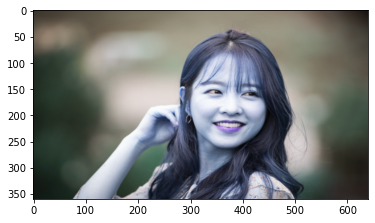

In [22]:
import os

# 나 대신 고양이 수염이 잘 어울릴 것 같은 박보영 사진을 들고 왔다.
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/boyoung.jpg'
img_bgr = cv2.imread(my_image_path) # open cv로 읽고
img_bgr = cv2.resize(img_bgr, (640, 360)) 
img_show = img_bgr.copy() # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

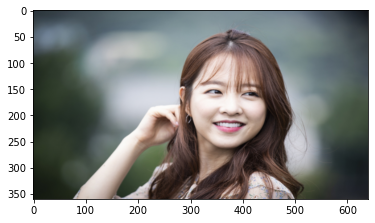

In [23]:
# bgr 에서 rgb로 바꿔서 푸르딩딩한 사진을 바꾸자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

---
# 2. Face detection
dlib의 face detector는 HOG(Histogram of oriented Gradient) feature를 이용해서 svm의 sliding window로 얼굴을 찾는다.

---

In [24]:
import dlib
detector_hog = dlib.get_frontal_face_detector() # detector선언
print('--')

--


In [25]:
# bounding box
import cv2
dlib_rects=detector_hog(img_rgb,1)
print('--')

--


## 이미지 피라미드 
* detector_hog의 두번째 파라미터가 이미지 피라미드
* 동일 이미지의 서로 다른 사이즈의 세트
* 업샘플링으로 크기를 키우는 것
* 이미지 피라미드에서 얼굴 검출시 작게 촬영된 얼굴을 크게 볼 수 있어 더 정확한 검출이 가능

In [26]:
print(dlib_rects) #얼굴영역 좌표

rectangles[[(311, 125) (440, 254)]]


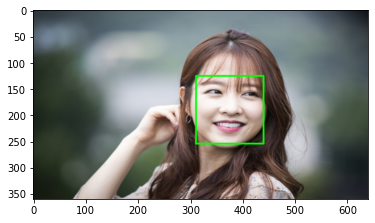

In [27]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()    
    r = dlib_rect.right()    
    b = dlib_rect.bottom()    
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()

---
# 3. Face landmark
---

In [28]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('--')

--


In [29]:
list_landmarks=[]
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb,dlib_rect) # dlib.full_object_detection 반환
    list_points=list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0])) #68개의 랜드마크가 얼굴 개수만큼 저장됨
print(list_landmarks[0][0])
print(list_landmarks)


68
(301, 157)
[[(301, 157), (301, 174), (302, 192), (305, 210), (311, 226), (323, 240), (338, 251), (354, 260), (372, 263), (390, 260), (406, 251), (421, 241), (434, 229), (441, 214), (444, 198), (446, 182), (447, 166), (318, 144), (330, 136), (345, 134), (360, 136), (373, 142), (390, 142), (403, 139), (417, 139), (430, 142), (439, 151), (381, 156), (381, 167), (381, 179), (381, 191), (363, 198), (371, 200), (379, 203), (387, 201), (394, 200), (334, 156), (344, 153), (353, 153), (361, 159), (352, 159), (343, 158), (400, 162), (410, 157), (418, 157), (425, 162), (418, 162), (410, 162), (343, 215), (357, 211), (369, 209), (377, 211), (385, 210), (396, 213), (406, 218), (395, 227), (384, 232), (375, 233), (367, 232), (355, 226), (346, 216), (369, 214), (377, 215), (385, 215), (403, 218), (384, 224), (376, 224), (368, 223)]]


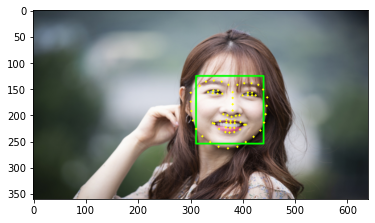

In [30]:
# 랜드마크 영상에 출력하기
for landmark in list_landmarks:
    for idx,point in enumerate(list_points):
        cv2.circle(img_show,point,2,(0,255,255),-1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---
# 4. 스티커 적용하기
---

1. landmark위치 
- landmark 위치 2,36,48,30번 인덱스 사용  

top-left 이미지 시작점 지정
- x: 30번 위치에서 - 수염 이미지의 가로 길이 절반 
- y: 30번 위치에서 - 수염 이미지의 세로 길이 절반

2. sticker크기  
length = dlib_rect.width()  
width = length*0.8  
height = length//3

In [31]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(381, 191)
(x,y) : (381,126)
(w,h) : (130,130)


In [32]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

# whiskers = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
# plt.imshow(whiskers)
# plt.show()

(130, 130, 3)


In [33]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (316,-4)


In [34]:
# y 좌표 음수 처리. 이미지 범위 밖 스티커를 제거 해야함.
img_sticker=img_sticker[-refined_y:]
print(img_sticker.shape)


(126, 130, 3)


In [35]:
# top y 좌표는 원본 이미지의 경계 값으로 수정
refined_y = 0
print('(x,y):(%d,%d)'%(refined_x,refined_y))

(x,y):(316,0)


In [36]:
# 원본 이미지에 스티커 적용

# 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지
print(img_bgr)
print(img_bgr.shape) # (360, 640, 3)
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

[[[58 53 44]
  [58 53 44]
  [58 53 44]
  ...
  [24 20 17]
  [23 20 16]
  [23 20 15]]

 [[58 53 44]
  [58 53 44]
  [59 53 44]
  ...
  [25 20 17]
  [24 19 16]
  [23 20 16]]

 [[58 53 44]
  [59 53 44]
  [60 53 44]
  ...
  [26 21 18]
  [25 20 17]
  [25 20 17]]

 ...

 [[16 23 18]
  [16 23 18]
  [17 24 19]
  ...
  [39 33 32]
  [38 33 32]
  [39 34 33]]

 [[17 23 18]
  [17 23 18]
  [17 24 19]
  ...
  [40 35 34]
  [40 35 34]
  [40 35 34]]

 [[16 23 18]
  [18 24 19]
  [17 24 19]
  ...
  [42 37 36]
  [41 36 35]
  [41 36 35]]]
(360, 640, 3)
(126, 130, 3)


## 생각해보기
np.where이용해서 스티커 적용
스티커 뒤로 원본 이미지가 같이 보이도록 (투명) - cv2.addWeighted()

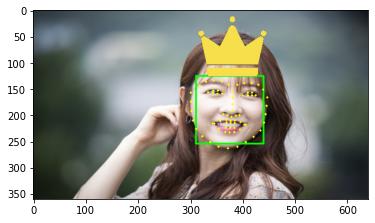

In [40]:
# 스티커에서 사용할 부분은 0이 아닌 색이 있는 부분 사용
# np.where통해 img_sticker가 0인 부분은 sticker_area를 사용
# 0이 아닌 부분을 img_sticker사용
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

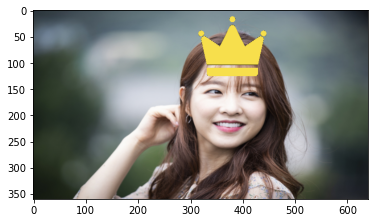

In [41]:
# bounding box와 landmark제거하고 최종 결과만 출력
# img_show 대신, img_rbg 활용

sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 찾아보기
- 다양한 각도에서 셀카 촬영, 반복 적용
- 문제점이 뭔지 최대한 자세히 기록
    -얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  
    
    -멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    
    -실행 속도가 중요할까요?
    
    -스티커앱을 만들 때 정확도가 얼마나 중요할까요?
